In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [256]:
train = pd.read_csv("data/sales_train.csv", encoding="utf-8")
test = pd.read_csv("data/test.csv", encoding="utf-8")
sub = pd.read_csv("data/sample_submission.csv", encoding="utf-8")

cats = pd.read_csv("data/item_categories.csv", encoding="utf-8")
items = pd.read_csv("data/items.csv", encoding="utf-8")
shops = pd.read_csv("data/shops.csv", encoding="utf-8")

In [257]:
# shops
# 상점 이름 변경
shops.loc[shops["shop_name"] == 'Сергиев Посад ТЦ "7Я"', "shop_name"] = 'СергиевПосад ТЦ "7Я"'

# 도시 정보 추출
shops["city_name"] = shops['shop_name'].str.split(' ').apply(lambda x: x[0])
shops["city_name"].value_counts()[:5]

# 도시 이름 대치
shops.loc[shops["city_name"] == "!Якутск", "city_name"] = "Якутск"

# 도시 이름 labelencoding
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(shops["city_name"])
shops["city_id"]=le.transform(shops["city_name"])

shops[:5]

,shop_name,shop_id,city_name,city_id
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


In [258]:
# cats
# 카테고리 정보 분리
cats["cats_main"]=cats['item_category_name'].str.split(" - ").apply(lambda x: x[0])
cats["cats_sub"]=cats['item_category_name'].str.split(" - ").apply(lambda x: x[1] if len(x)>1 else x[0])

# 카테고리 정보 labelencoding
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

le.fit(cats["cats_main"])
cats["cats_main_id"]=le.transform(cats["cats_main"])

le.fit(list(cats["cats_sub"]))
cats["cats_sub_id"]=le.transform(cats["cats_sub"])

cats[:5]

,item_category_name,item_category_id,cats_main,cats_sub,cats_main_id,cats_sub_id
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники,0,31
1,Аксессуары - PS2,1,Аксессуары,PS2,1,11
2,Аксессуары - PS3,2,Аксессуары,PS3,1,12
3,Аксессуары - PS4,3,Аксессуары,PS4,1,13
4,Аксессуары - PSP,4,Аксессуары,PSP,1,15


In [259]:
# items
items[:5]

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [260]:
# train
# 중복값, 이상치 제거

# 판매 개수
train = train[train["item_cnt_day"] < 1001] # 1001 이상의 값 제거
train = train[train["item_cnt_day"] >= 0]   # 0보다 작은 값 제거 1개

# 가격
train = train[train["item_price"] < 100000]
train = train[train["item_price"] >= 0]

In [261]:
# trian의 월, 상점, 아이템 조합
from itertools import product
matrix=[]
col=["date_block_num", "shop_id", "item_id"]
for i in range(34): # train date_block_num 0~33 반복
    con = train[train["date_block_num"]==i]
    matrix.append(np.array(list(product([i], set(con["shop_id"]), set(con["item_id"])))))
matrix=pd.DataFrame(np.row_stack(matrix), columns=col)
matrix.sort_values(col, inplace=True)

In [262]:
matrix[:5]

,date_block_num,shop_id,item_id
0,0,0,19
1,0,0,27
2,0,0,28
3,0,0,29
4,0,0,32


In [263]:
# len(matrix) # 10913850 >> 전처리(중복값 이상치 제거) 전 matrix
len(matrix) # 10884508 >> 전처리 후 matrix 10884508

10884508

In [264]:
# train data target 값 생성
cols = ["date_block_num", "shop_id", "item_id"]
item_cnt_month=train.groupby(col).agg({"item_cnt_day":["sum"]})
item_cnt_month.columns = ["item_cnt_month"]
item_cnt_month.reset_index(inplace=True)
item_cnt_month[:5]

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [265]:
# matrix에 target값 추가
df = pd.merge(matrix, item_cnt_month, on = col, how = "left")
df[:5]

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,NaN
1,0,0,27,NaN
2,0,0,28,NaN
3,0,0,29,NaN
4,0,0,32,6.0


In [266]:
# traget값 clip(0, 20)
df["item_cnt_month"] = df["item_cnt_month"].clip(0, 20)
df[:5]

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,NaN
1,0,0,27,NaN
2,0,0,28,NaN
3,0,0,29,NaN
4,0,0,32,6.0


In [267]:
# matrix에 test 데이터 추가
test["date_block_num"] = 34
ndf = pd.concat([df, test], ignore_index=True, sort=False)
ndf[:5]

,date_block_num,shop_id,item_id,item_cnt_month,ID
0,0,0,19,NaN,NaN
1,0,0,27,NaN,NaN
2,0,0,28,NaN,NaN
3,0,0,29,NaN,NaN
4,0,0,32,6.0,NaN


In [268]:
# 결측값 0으로 변환
ndf["item_cnt_month"] = ndf["item_cnt_month"].fillna(0)
ndf["ID"] = ndf["ID"].fillna(0)

In [269]:
# matrix에 추가정보 병합
ndf = pd.merge(ndf, shops, on=["shop_id"], how="left")
ndf = pd.merge(ndf, items, on=["item_id"], how="left")
ndf = pd.merge(ndf, cats, on=["item_category_id"], how="left")

In [270]:
ndf[:5]

,date_block_num,shop_id,item_id,item_cnt_month,ID,shop_name,city_name,city_id,item_name,item_category_id,item_category_name,cats_main,cats_sub,cats_main_id,cats_sub_id
0,0,0,19,0.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD,Кино,DVD,11,6
1,0,0,27,0.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,"007 Legends [PS3, русская версия]",19,Игры - PS3,Игры,PS3,5,12
2,0,0,28,0.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,"007 Legends [PС, Jewel, русская версия]",30,Игры PC - Стандартные издания,Игры PC,Стандартные издания,8,57
3,0,0,29,0.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,"007 Legends [Xbox 360, русская версия]",23,Игры - XBOX 360,Игры,XBOX 360,5,18
4,0,0,32,6.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,1+1,40,Кино - DVD,Кино,DVD,11,6


In [271]:
# 필요없는 컬럼제거
df_rm = ndf.drop(["shop_name", "city_name", "item_name", "item_category_name", "cats_main", "cats_sub"], axis=1)
df_rm[:5]

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_id,item_category_id,cats_main_id,cats_sub_id
0,0,0,19,0.0,0.0,29,40,11,6
1,0,0,27,0.0,0.0,29,19,5,12
2,0,0,28,0.0,0.0,29,30,8,57
3,0,0,29,0.0,0.0,29,23,5,18
4,0,0,32,6.0,0.0,29,40,11,6


In [272]:
# 추가변수
df_rm["month"] = df_rm["date_block_num"] % 12 # 월
df_rm[:5]

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_id,item_category_id,cats_main_id,cats_sub_id,month
0,0,0,19,0.0,0.0,29,40,11,6,0
1,0,0,27,0.0,0.0,29,19,5,12,0
2,0,0,28,0.0,0.0,29,30,8,57,0
3,0,0,29,0.0,0.0,29,23,5,18,0
4,0,0,32,6.0,0.0,29,40,11,6,0


In [273]:
# lag값 추가할 함수
def lag_feature(df, lags, col):
    tmp = df[["date_block_num", "shop_id", "item_id",col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ["date_block_num","shop_id","item_id", col+"_lag_"+str(i)]
        shifted["date_block_num"] += i
        df = pd.merge(df, shifted, on=["date_block_num","shop_id","item_id"], how="left")
    return df

In [274]:
# 1, 2, 3, 6, 12개월 전의 (월별, 상점별, 아이템의 판매량)을 변수로 추가
df_rm_t = lag_feature(df_rm, [1,2,3,6,12], "item_cnt_month")

In [275]:
# lag 확인
df_rm_t[(df_rm_t["shop_id"] == 42) & (df_rm_t["item_id"] == 21928)][:13]
# df_rm_t[(df_rm_t["shop_id"] == 42) & (df_rm_t["item_id"] == 21928)][-5:]

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_id,item_category_id,cats_main_id,cats_sub_id,month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
267553,0,42,21928,1.0,0.0,19,55,13,4,0,NaN,NaN,NaN,NaN,NaN
642516,1,42,21928,0.0,0.0,19,55,13,4,1,1.0,NaN,NaN,NaN,NaN
1006105,2,42,21928,0.0,0.0,19,55,13,4,2,0.0,1.0,NaN,NaN,NaN
1374641,3,42,21928,0.0,0.0,19,55,13,4,3,0.0,0.0,1.0,NaN,NaN
1738716,4,42,21928,0.0,0.0,19,55,13,4,4,0.0,0.0,0.0,NaN,NaN
2126460,5,42,21928,0.0,0.0,19,55,13,4,5,0.0,0.0,0.0,NaN,NaN
2514102,6,42,21928,0.0,0.0,19,55,13,4,6,0.0,0.0,0.0,1.0,NaN
2880847,7,42,21928,0.0,0.0,19,55,13,4,7,0.0,0.0,0.0,0.0,NaN
3237413,8,42,21928,0.0,0.0,19,55,13,4,8,0.0,0.0,0.0,0.0,NaN
3604697,9,42,21928,0.0,0.0,19,55,13,4,9,0.0,0.0,0.0,0.0,NaN


In [276]:
# lag로 11개월 값 제거
df_rm_t = df_rm_t[df_rm_t["date_block_num"] > 11]
df_rm_t[:5]

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_id,item_category_id,cats_main_id,cats_sub_id,month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
4478844,12,2,27,0.0,0.0,0,19,5,12,0,0.0,0.0,0.0,0.0,1.0
4478845,12,2,30,0.0,0.0,0,40,11,6,0,0.0,0.0,0.0,0.0,NaN
4478846,12,2,31,0.0,0.0,0,37,11,1,0,0.0,0.0,0.0,0.0,NaN
4478847,12,2,32,1.0,0.0,0,40,11,6,0,0.0,0.0,0.0,0.0,0.0
4478848,12,2,33,1.0,0.0,0,37,11,1,0,1.0,2.0,0.0,0.0,1.0


In [277]:
df_rm_t.isnull().sum()

date_block_num                 0
shop_id                        0
item_id                        0
item_cnt_month                 0
ID                             0
city_id                        0
item_category_id               0
cats_main_id                   0
cats_sub_id                    0
month                          0
item_cnt_month_lag_1     1395555
item_cnt_month_lag_2     1605580
item_cnt_month_lag_3     1808365
item_cnt_month_lag_6     2386708
item_cnt_month_lag_12    3503037
dtype: int64

In [278]:
df_rm_t.fillna(0, inplace=True)

In [279]:
df_rm_t.isnull().sum()

date_block_num           0
shop_id                  0
item_id                  0
item_cnt_month           0
ID                       0
city_id                  0
item_category_id         0
cats_main_id             0
cats_sub_id              0
month                    0
item_cnt_month_lag_1     0
item_cnt_month_lag_2     0
item_cnt_month_lag_3     0
item_cnt_month_lag_6     0
item_cnt_month_lag_12    0
dtype: int64

In [280]:
df_rm_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6619864 entries, 4478844 to 11098707
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   date_block_num         int64  
 1   shop_id                int64  
 2   item_id                int64  
 3   item_cnt_month         float64
 4   ID                     float64
 5   city_id                int32  
 6   item_category_id       int64  
 7   cats_main_id           int32  
 8   cats_sub_id            int32  
 9   month                  int64  
 10  item_cnt_month_lag_1   float64
 11  item_cnt_month_lag_2   float64
 12  item_cnt_month_lag_3   float64
 13  item_cnt_month_lag_6   float64
 14  item_cnt_month_lag_12  float64
dtypes: float64(7), int32(3), int64(5)
memory usage: 732.3 MB


In [281]:
final_df = df_rm_t[["date_block_num", "shop_id", "item_id", "item_cnt_month",
        "city_id", "item_category_id", "cats_main_id", "cats_sub_id",
        "item_cnt_month_lag_1", "item_cnt_month_lag_2", "item_cnt_month_lag_3" , "item_cnt_month_lag_6", "item_cnt_month_lag_12"]] # target varialbe lag (월별 / 상점별 / 상품별 / 판매량(sum))

In [282]:
final_df.corr()

,date_block_num,shop_id,item_id,item_cnt_month,city_id,item_category_id,cats_main_id,cats_sub_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
date_block_num,1.000000,0.004903,-0.015188,-0.019299,0.004717,0.029153,-0.007228,0.088855,-0.016277,-0.015427,-0.012514,-0.004189,0.002588
shop_id,0.004903,1.000000,-0.000201,0.017762,0.986220,-0.000286,-0.000431,0.000432,0.018611,0.018291,0.018040,0.016758,0.012234
item_id,-0.015188,-0.000201,1.000000,-0.046108,-0.000152,0.168753,0.291661,-0.124584,-0.049099,-0.050547,-0.050757,-0.053533,-0.052588
item_cnt_month,-0.019299,0.017762,-0.046108,1.000000,0.016723,-0.078108,-0.101204,0.029778,0.573802,0.451555,0.390037,0.296167,0.208435
city_id,0.004717,0.986220,-0.000152,0.016723,1.000000,-0.000211,-0.000339,0.000354,0.017403,0.017151,0.017036,0.016123,0.011474
item_category_id,0.029153,-0.000286,0.168753,-0.078108,-0.000211,1.000000,0.930139,0.268003,-0.084166,-0.085228,-0.085647,-0.086898,-0.078377
cats_main_id,-0.007228,-0.000431,0.291661,-0.101204,-0.000339,0.930139,1.000000,0.059594,-0.107656,-0.107797,-0.107278,-0.106568,-0.093382
cats_sub_id,0.088855,0.000432,-0.124584,0.029778,0.000354,0.268003,0.059594,1.000000,0.027796,0.027029,0.025907,0.025421,0.028035
item_cnt_month_lag_1,-0.016277,0.018611,-0.049099,0.573802,0.017403,-0.084166,-0.107656,0.027796,1.000000,0.589351,0.461299,0.322034,0.220942
item_cnt_month_lag_2,-0.015427,0.018291,-0.050547,0.451555,0.017151,-0.085228,-0.107797,0.027029,0.589351,1.000000,0.591314,0.348793,0.231723


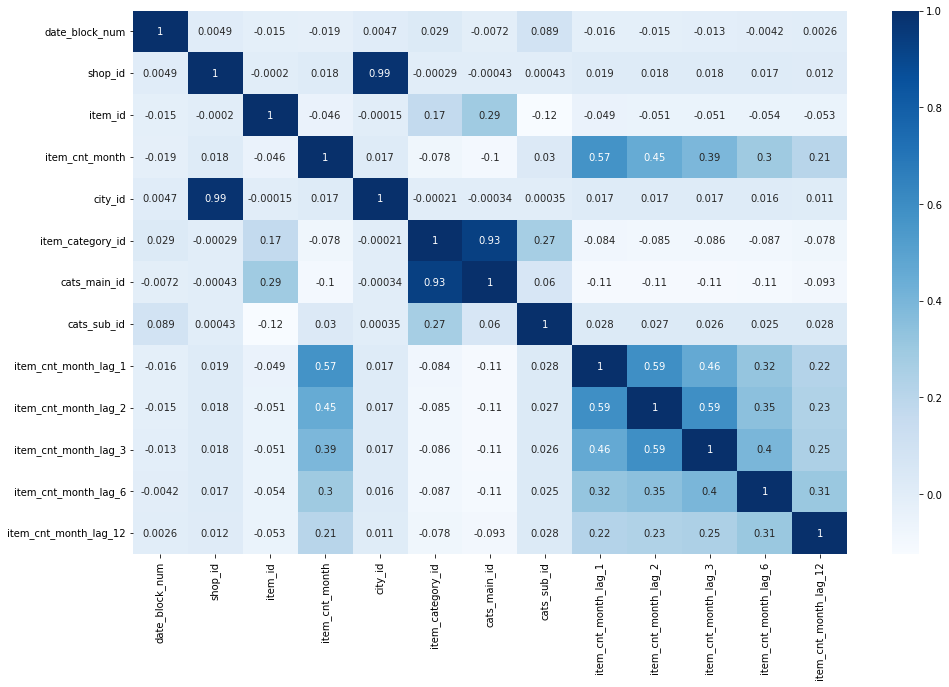

In [283]:
plt.figure(figsize=(16, 10))
sns.heatmap(final_df.corr(), annot=True, cmap="Blues")
plt.show()

In [284]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6619864 entries, 4478844 to 11098707
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   date_block_num         int64  
 1   shop_id                int64  
 2   item_id                int64  
 3   item_cnt_month         float64
 4   city_id                int32  
 5   item_category_id       int64  
 6   cats_main_id           int32  
 7   cats_sub_id            int32  
 8   item_cnt_month_lag_1   float64
 9   item_cnt_month_lag_2   float64
 10  item_cnt_month_lag_3   float64
 11  item_cnt_month_lag_6   float64
 12  item_cnt_month_lag_12  float64
dtypes: float64(6), int32(3), int64(4)
memory usage: 631.3 MB


In [285]:
X_train = final_df[final_df["date_block_num"] < 33].drop(["item_cnt_month"], axis=1)
y_train = final_df[final_df["date_block_num"] < 33]["item_cnt_month"]

X_valid = final_df[final_df["date_block_num"] == 33].drop(["item_cnt_month"], axis=1)
y_valid = final_df[final_df["date_block_num"] == 33]["item_cnt_month"]

X_test = final_df[final_df["date_block_num"] == 34].drop(["item_cnt_month"], axis=1)

In [286]:
y_valid

10646424    0.0
10646425    1.0
10646426    0.0
10646427    0.0
10646428    0.0
           ... 
10884503    0.0
10884504    0.0
10884505    0.0
10884506    0.0
10884507    0.0
Name: item_cnt_month, Length: 238084, dtype: float64

In [287]:
# train-test data scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler().fit(X_train)      # train data scale 정보 저장

X_train_scaled = sc.transform(X_train)  # train data scale
X_valid_scaled = sc.transform(X_valid)    # test data scale

In [310]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12).fit(X_train_scaled) # train data로 PCA
X_train_pca = pca.transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)

In [311]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_pca, y_train)   # train fit

LinearRegression()

In [312]:
model.score(X_valid_pca, y_valid)

0.2609927568588273

In [313]:
# 회귀식
print("w", model.coef_, "\n",
      "b", model.intercept_)

w [ 0.38534226  0.02868903  0.16866141  0.0299582  -0.00203532 -0.14212587
 -0.00859133  0.11491348  0.28446584  0.16744965 -0.07281574 -0.0178185 ] 
 b 0.29034207906504644


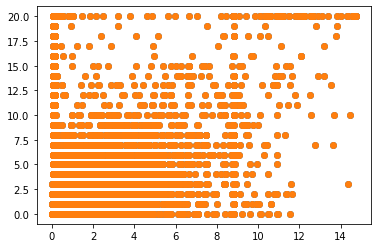

In [314]:
y_valid_pred = model.predict(X_valid_pca)
plt.scatter(y_valid_pred, y_valid) # 실제 값
plt.scatter(y_valid_pred, y_valid)
plt.show()

In [315]:
result = pd.DataFrame(y_valid_pred, y_valid)
result.columns = ["y_pred"]
result

,y_pred
item_cnt_month,
0.0,0.056296
1.0,0.046962
0.0,0.251909
0.0,0.626487
0.0,0.057296
...,...
0.0,0.242925
0.0,0.074248
0.0,0.274713


In [316]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_score = sqrt(mean_squared_error(y_valid, y_valid_pred))
rmse_score

0.9776101769998147

## test data 예측

In [317]:
X_test_scaled = sc.transform(X_test)        # test_data scale
X_test_pca = pca.transform(X_test_scaled)   # test_data pca
y_test_pred = model.predict(X_test_pca)     # test_data predict
y_test_pred

array([0.59360008, 0.05083251, 1.16005934, ..., 0.06756948, 0.07416182,
       0.06128011])

In [318]:
sub["item_cnt_month"] = y_test_pred
sub

,ID,item_cnt_month
0,0,0.593600
1,1,0.050833
2,2,1.160059
3,3,0.231613
4,4,0.142446
...,...,...
214195,214195,0.502788
214196,214196,0.078461
214197,214197,0.067569
214198,214198,0.074162


In [319]:
import datetime
time = datetime.datetime.now().strftime("%m_%d_%H%M")

In [320]:
# submission file
# name: 사용모델_생성시간_검증점수
sub.to_csv(f"c:/Users/nonil/new/projects/kaggle_study_subject/{model}_{time}_{rmse_score:.5f}.csv", index=False)